# Proyecto RustyBargain predicción de valor de mercado

El servicio de venta de autos usados Rusty Bargain está desarrollando una aplicación para atraer nuevos clientes. Gracias a esa app, puedes averiguar rápidamente el valor de mercado de tu coche. Tienes acceso al historial: especificaciones técnicas, versiones de equipamiento y precios. Tienes que crear un modelo que determine el valor de mercado.
A Rusty Bargain le interesa:
- la calidad de la predicción;
- la velocidad de la predicción;
- el tiempo requerido para el entrenamiento

## Preparación de datos

In [1]:
# Importar librerias
import pandas as pd
import numpy as np
import time
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import xgboost as xgb
from lightgbm import basic as _lgb_basic


In [2]:
# Cargar los datos
df = pd.read_csv('datasets/car_data.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [3]:
# Eliminar columnas irrelevantes
columnas_a_eliminar = [
    'DateCrawled',
    'DateCreated',
    'LastSeen',
    'NumberOfPictures',
    'PostalCode'
]

df.drop(columns=columnas_a_eliminar, inplace=True)

# Verificamos las columnas restantes
print("Columnas después de limpieza:")
df.columns.tolist()

Columnas después de limpieza:


['Price',
 'VehicleType',
 'RegistrationYear',
 'Gearbox',
 'Power',
 'Model',
 'Mileage',
 'RegistrationMonth',
 'FuelType',
 'Brand',
 'NotRepaired']

**NOTAS:**

Se eliminaron estas columnas porque no aportan datos importantes para el precio del coche y provoca una sobrecarga de información.

In [4]:
df.columns = df.columns.str.lower()

df.head()

,price,vehicletype,registrationyear,gearbox,power,model,mileage,registrationmonth,fueltype,brand,notrepaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


In [5]:
# Filtrar valores ilógicos
df = df[(df['power'] > 9) & (df['power'] < 600)]  # Valores razonables de potencia
df = df[(df['price'] > 899) & (df['price'] < 100000)]  # Precio razonable
df = df[df['registrationyear'].between(1950, 2025)]  # Años válidos
df = df[(df['registrationmonth'] > 0) & (df['registrationmonth'] < 13)]  # Meses válidos

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 246258 entries, 1 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              246258 non-null  int64 
 1   vehicletype        234476 non-null  object
 2   registrationyear   246258 non-null  int64 
 3   gearbox            243042 non-null  object
 4   power              246258 non-null  int64 
 5   model              238733 non-null  object
 6   mileage            246258 non-null  int64 
 7   registrationmonth  246258 non-null  int64 
 8   fueltype           235723 non-null  object
 9   brand              246258 non-null  object
 10  notrepaired        218682 non-null  object
dtypes: int64(5), object(6)
memory usage: 22.5+ MB


In [6]:
# Encontrar todas las filas duplicadas
duplicados = df.duplicated()
print("Valores duplicados de car_data: ", duplicados.sum())

# Eliminar filas duplicadas, manteniendo la primera aparición
df = df.drop_duplicates()
print("Valores duplicados de car_data: ", df.duplicated().sum())


Valores duplicados de car_data:  20372


Valores duplicados de car_data:  0


In [7]:
# Reemplazar valores faltantes en columnas categóricas
categ_cols = ['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'notrepaired']
for col in categ_cols:
    df[col] = df[col].fillna('unknown').astype('category')


# Encontrar columnas con valores nulos
columnas_nulas = df.isnull().any()
columnas_con_nulos = columnas_nulas[columnas_nulas].index.tolist()
print(columnas_con_nulos)

[]


In [8]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 225886 entries, 1 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   price              225886 non-null  int64   
 1   vehicletype        225886 non-null  category
 2   registrationyear   225886 non-null  int64   
 3   gearbox            225886 non-null  category
 4   power              225886 non-null  int64   
 5   model              225886 non-null  category
 6   mileage            225886 non-null  int64   
 7   registrationmonth  225886 non-null  int64   
 8   fueltype           225886 non-null  category
 9   brand              225886 non-null  category
 10  notrepaired        225886 non-null  category
dtypes: category(6), int64(5)
memory usage: 11.9 MB


,price,registrationyear,power,mileage,registrationmonth
count,225886.000000,225886.000000,225886.000000,225886.000000,225886.000000
mean,5702.165871,2004.117763,126.785662,125880.665468,6.405806
std,4612.741669,6.641724,54.083721,37794.508900,3.343020
min,900.000000,1950.000000,10.000000,5000.000000,1.000000
25%,2000.000000,2001.000000,90.000000,100000.000000,4.000000
50%,4000.000000,2004.000000,116.000000,150000.000000,6.000000
75%,7999.000000,2008.000000,150.000000,150000.000000,9.000000
max,20000.000000,2019.000000,585.000000,150000.000000,12.000000


## Entrenamiento del modelo 

In [9]:
features = df.drop('price', axis=1)
target = df['price']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=1234)


In [10]:
# One-Hot Encoding para modelos que lo requieren
features_train_ohe = pd.get_dummies(features_train, drop_first=True)
features_test_ohe = pd.get_dummies(features_test, drop_first=True)
features_test_ohe = features_test_ohe.reindex(columns=features_train_ohe.columns, fill_value=0)

# Función auxiliar de RMSE (RECM)
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [11]:
results = {}

# --- 1. Regresión Lineal ---
lr = LinearRegression()
start = time.time()
lr.fit(features_train_ohe, target_train)
train_time = time.time() - start

start = time.time()
preds_lr = lr.predict(features_test_ohe)
predict_time = time.time() - start

results['LinearRegression'] = {
    'rmse': rmse(target_test, preds_lr),
    'train_time': train_time,
    'predict_time': predict_time
}

# --- 2. Árbol de decisión ---
tree = DecisionTreeRegressor(max_depth=10, random_state=42)
start = time.time()
tree.fit(features_train_ohe, target_train)
train_time = time.time() - start

start = time.time()
preds_tree = tree.predict(features_test_ohe)
predict_time = time.time() - start

results['DecisionTree'] = {
    'rmse': rmse(target_test, preds_tree),
    'train_time': train_time,
    'predict_time': predict_time
}


In [12]:
# --- 3. Random Forest ---
rf = RandomForestRegressor(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1)
start = time.time()
rf.fit(features_train_ohe, target_train)
train_time = time.time() - start

start = time.time()
preds_rf = rf.predict(features_test_ohe)
predict_time = time.time() - start

results['RandomForest'] = {
    'rmse': rmse(target_test, preds_rf),
    'train_time': train_time,
    'predict_time': predict_time
}


KeyboardInterrupt: 

In [23]:
# --- 4. LightGBM (usa features sin OHE y pasa categóricas) ---
# Identificar categóricas por nombre
categorical_features = ['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'notrepaired']

lgbm = lgb.LGBMRegressor(num_leaves=31, learning_rate=0.1, n_estimators=100, random_state=42)
start = time.time()
lgbm.fit(
    features_train,
    target_train,
    categorical_feature=categorical_features,
    eval_set=[(features_test, target_test)]
)
train_time = time.time() - start

start = time.time()
preds_lgb = lgbm.predict(features_test)
predict_time = time.time() - start

results['LightGBM'] = {
    'rmse': rmse(target_test, preds_lgb),
    'train_time': train_time,
    'predict_time': predict_time
}

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004601 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 169414, number of used features: 10
[LightGBM] [Info] Start training from score 5700.582821


In [24]:
# --- 5. CatBoost (maneja categóricas directamente) ---
cat_features_idx = [features.columns.get_loc(col) for col in categorical_features]

cat = CatBoostRegressor(
    iterations=1000,                   # límite alto pero early stopping corta
    learning_rate=0.1,
    depth=6,
    early_stopping_rounds=20,
    verbose=False,
    random_seed=42,
    thread_count=-1,                   # usa todos los núcleos
    border_count=64,                  # menos bins = más rápido
    grow_policy='SymmetricTree',       # más rápido en muchos casos; opcional
    # Si tienes GPU descomenta:
    # task_type='GPU',
    # devices='0',
)

start = time.time()
cat.fit(
    features_train,
    target_train,
    cat_features=cat_features_idx,
    eval_set=(features_test, target_test),
    use_best_model=True
)
train_time = time.time() - start

start = time.time()
preds_cat = cat.predict(features_test)
predict_time = time.time() - start

results['CatBoost'] = {
    'rmse': rmse(target_test, preds_cat),
    'train_time': train_time,
    'predict_time': predict_time
}


In [25]:
# --- 6. XGBoost (requiere OHE) ---
dtrain = xgb.DMatrix(features_train_ohe, label=target_train)
dtest = xgb.DMatrix(features_test_ohe, label=target_test)

xgb_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'eta': 0.1,
    'max_depth': 6,
    'subsample': 0.8,             # muestreo de filas
    'colsample_bytree': 0.8,      # muestreo de características
    'tree_method': 'hist',        # más rápido que el exacto; usa 'gpu_hist' si tienes GPU
    'seed': 42,
    # 'disable_default_eval_metric': 1  # opcional para evitar métricas extra
}

start = time.time()
xgb_model = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=500,
    evals=[(dtest, 'validation')],
    early_stopping_rounds=20,
    verbose_eval=False
)
train_time = time.time() - start

start = time.time()
preds_xgb = xgb_model.predict(dtest, iteration_range=(0, xgb_model.best_iteration + 1))
predict_time = time.time() - start

results['XGBoost'] = {
    'rmse': rmse(target_test, preds_xgb),
    'train_time': train_time,
    'predict_time': predict_time
}

In [26]:
# --- Mostrar resumen ---
for name, res in results.items():
    print(f"{name:15} | RMSE: {res['rmse']:.2f} | Train(s): {res['train_time']:.3f} seg| Predict(s): {res['predict_time']:.4f} seg")

LinearRegression | RMSE: 2610.82 | Train(s): 7.712 seg| Predict(s): 0.4690 seg
DecisionTree    | RMSE: 2056.46 | Train(s): 4.046 seg| Predict(s): 0.1287 seg
RandomForest    | RMSE: 1690.84 | Train(s): 152.959 seg| Predict(s): 0.8038 seg
LightGBM        | RMSE: 1661.70 | Train(s): 2.257 seg| Predict(s): 0.1172 seg
CatBoost        | RMSE: 1644.38 | Train(s): 93.373 seg| Predict(s): 0.1760 seg
XGBoost         | RMSE: 1635.15 | Train(s): 20.710 seg| Predict(s): 0.2187 seg


## Análisis del modelo

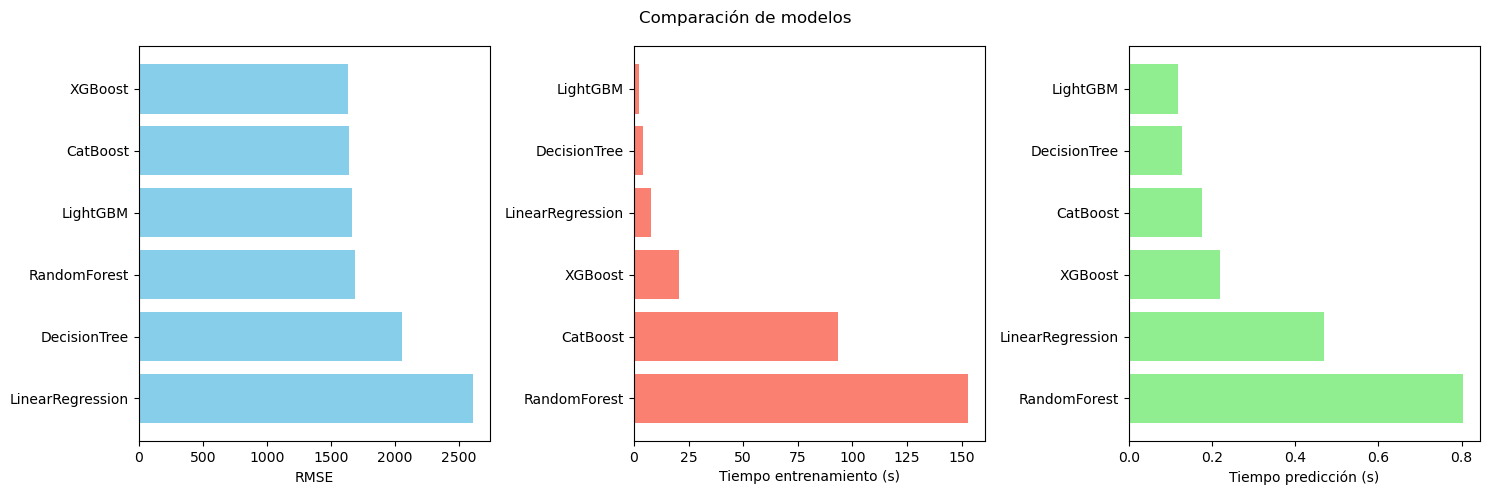

In [27]:
# Convertir resultados a DataFrame
df_results = pd.DataFrame.from_dict(results, orient='index').reset_index().rename(columns={'index': 'model'})

# --- BARRAS COMPARATIVAS---
fig, axes = plt.subplots(1, 3, figsize=(15,5))

# RMSE
df_rmse_sorted = df_results.sort_values('rmse', ascending=True)
axes[0].barh(df_rmse_sorted['model'], df_rmse_sorted['rmse'], color='skyblue')
axes[0].set_xlabel('RMSE')
axes[0].invert_yaxis()

# Train time
df_train_sorted = df_results.sort_values('train_time', ascending=True)
axes[1].barh(df_train_sorted['model'], df_train_sorted['train_time'], color='salmon')
axes[1].set_xlabel('Tiempo entrenamiento (s)')
axes[1].invert_yaxis()

# Predict time
df_predict_sorted = df_results.sort_values('predict_time', ascending=True)
axes[2].barh(df_predict_sorted['model'], df_predict_sorted['predict_time'], color='lightgreen')
axes[2].set_xlabel('Tiempo predicción (s)')
axes[2].invert_yaxis()

fig.suptitle('Comparación de modelos')
plt.tight_layout()
plt.show()


### Conclusión

Dado que la empresa quiere calidad de predicción, velocidad de predicción y entrenamiento razonable, el mejor balance es **LightGBM**:

    RMSE: 1661.7 (muy cerca del mejor).

    Train: 2.257 seg (apto para reentrenar frecuentemente).

    Predict: 0.1172 seg. (el más rápido)

**LightGBM sería el modelo final recomendado.**

Si se quisiera mejorar un poco más sin perder mucha velocidad, se podría optimizar hiperparámetros de LightGBM y posiblemente lograr un RMSE menor.


Por otro lado, **XGBoost** fue el mejor en *RMSE = 1635.15* con una velocidad de entrenamiento *(Train) de 20.71 seg.* (casi 10 veces más que **LightGBM**).